In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
sns.set(font_scale=1.5)

**************************************************

Parcel workplace param sweep

**************************************************

In [2]:
df = pd.read_csv('param_sweep.csv')
df['NRecovered'] = df['FracRecovered']*df['NStaff']

Get variables

In [12]:
print(len(df))
TD = np.unique(df["tD"])
Phi = np.unique(df["phi"])
II = np.unique(df["InfInit"])
#parameter reminder
print('Pisol = ', np.unique(df['Pisol']))
print('Random contact rate = ', np.unique(df['p_contact']))
print('Friend contact prob = ', np.unique(df['p_friend_contact']))
print('Staff totals = ', np.unique(df['NStaff']))

6000000
Pisol =  [0.5]
Random contact rate =  [0.02941176]
Friend contact prob =  [1.]
Staff totals =  [10 20 38 68]


Calculate outbreak probabilities
Calculate poisson stats for each case

In [4]:
a_outbreak = np.zeros((len(TD),len(Phi),len(II)))
poisson_lowci = np.zeros((len(TD),len(Phi),len(II)))
poisson_uppci = np.zeros((len(TD),len(Phi),len(II)))
a_outbreak5 = np.zeros((len(TD),len(Phi),len(II)))
poisson_lowci_5 = np.zeros((len(TD),len(Phi),len(II)))
poisson_uppci_5 = np.zeros((len(TD),len(Phi),len(II)))



dfall = df.loc[lambda df: (df['Group'] == 'All')]
for (i,td) in enumerate(TD):
    dfi =  dfall.loc[lambda dfall: (dfall['tD'] == td)]
    for (j,phi) in enumerate(Phi):
        dfij =  dfi.loc[lambda dfi: (dfi['phi'] == phi)]
        for (k,ii) in enumerate(II):
            dfijk =  dfij.loc[lambda dfij: (dfij['InfInit'] == ii)]
            nh = np.sum(dfijk['FracRecovered'] > 1/dfijk['NStaff'])
            qlh = stats.poisson.ppf(0.025,nh)
            quh = stats.poisson.ppf(0.975,nh)
            a_outbreak[i,j,k] = nh/len(dfijk)
            poisson_lowci[i,j,k] = qlh/len(dfijk)
            poisson_uppci[i,j,k] = quh/len(dfijk)
            
            nh = np.sum(dfijk['FracRecovered'] > 5/dfijk['NStaff'])
            qlh = stats.poisson.ppf(0.025,nh)
            quh = stats.poisson.ppf(0.975,nh)
            poisson_lowci_5[i,j,k] = qlh/len(dfijk)
            poisson_uppci_5[i,j,k] = quh/len(dfijk)
            a_outbreak5[i,j,k] = nh/len(dfijk)
            

Index case to outbreak relation

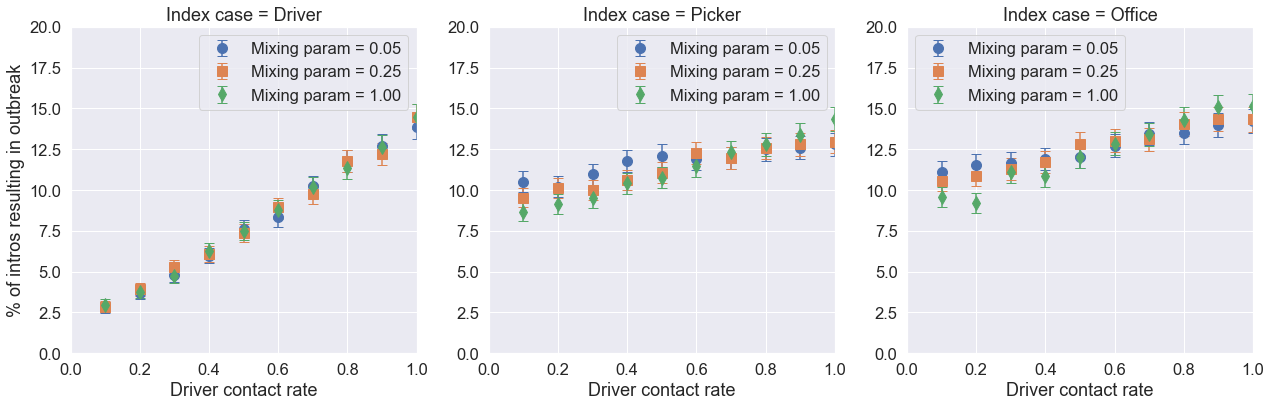

In [5]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
job = ['Driver','Picker','Office']
shape = ['o','s','d']
for (j,ii) in enumerate(II):
    for (k,phi) in enumerate(Phi[[0,2,4]]):
        ax[j].errorbar(TD,100*a_outbreak5[:,k,j],
                    (100*(a_outbreak5[:,k,j] - poisson_lowci_5[:,k,j]),
                    100*(poisson_uppci_5[:,k,j] - a_outbreak5[:,k,j])),
                    fmt=shape[k],capsize=5,markersize=10,label='Mixing param = %.2f'%phi)
    ax[j].legend()
    ax[j].set_xlabel('Driver contact rate')
                     
    ax[j].set_title('Index case = %s'%job[j])
    ax[j].set_xlim((0,1))
    ax[j].set_ylim((0,20))
ax[0].set_ylabel('% of intros resulting in outbreak')
fig.tight_layout()
fig.savefig('param_sweep_outbreak_probability.png')

Contour plot of mean outbreak size

/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


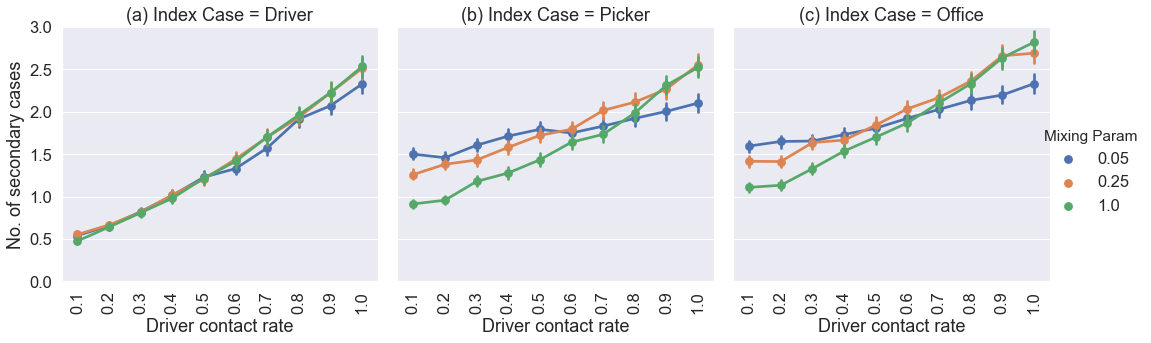

In [6]:
dfphi =  dfall.loc[lambda df: ((df['phi'] == 0.05) | (df['phi'] == 0.25) | (df['phi'] == 1.0))]
dfphi['Ninfected'] = (dfphi.loc[:,'FracRecovered']*dfphi.loc[:,'NStaff'] - 1)

sp = sns.catplot(x='tD',y='Ninfected', hue='phi',col='InfInit',data=dfphi,kind='point')
sp.set(ylim=(0,3),xlabel='Driver contact rate')
axes = sp.axes.flatten()
axes[0].set_ylabel('No. of secondary cases')
lab = ['a','b','c']
for i in range(3):
    axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
sp._legend.set_title('Mixing Param')
sp.set_xticklabels(rotation=90)
sp.savefig('Secondary_infections.png')

count customers infected

In [7]:
NPdel = 3000*np.tile([0.87,1.0,1.0,0.98,0.91,0.55,0],52)
NPcum = np.cumsum(NPdel)
frac_infected = np.zeros(len(df))
NPdeliveredapprox = np.zeros(len(df))
NPdeliveredapprox = NPcum[df['OverallOutbreakLength']-1]
frac_infected = df['CustomersInfectedByDrivers'] / NPdeliveredapprox

meancfrac = np.zeros((len(II),len(Phi),len(TD)))
stdcfrac = np.zeros((len(II),len(Phi),len(TD)))
cicfrac  = np.zeros((3,len(II),len(Phi),len(TD)))
quantiles = [0.025, 0.5, 0.975]
for (i,ii) in enumerate(II):
    seli = (df['InfInit'] == ii)
    for (j,phi) in enumerate(Phi):
        selj = (df['phi'] == phi) & seli
        for (k,td) in enumerate(TD):
            selk = (df['tD'] == td) & selj
            meancfrac[i,j,k] = np.mean(frac_infected[selk])
            stdcfrac[i,j,k] = np.std(frac_infected[selk])
            for (l,q) in enumerate(quantiles):
                cicfrac[l,i,j,k] = np.quantile(frac_infected[selk],q)

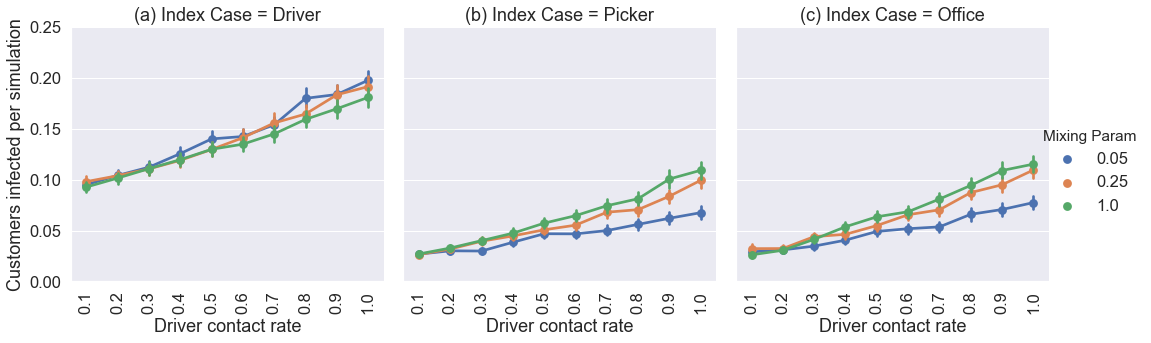

In [8]:
dfh = df[lambda df: (df['phi'] == Phi[0]) | (df['phi'] == Phi[2]) | (df['phi'] == Phi[4])]

sp = sns.catplot(x='tD',y='CustomersInfectedByDrivers',col='InfInit',hue='phi',data=dfh,kind='point')
sp.set(ylim=(0,0.25),xlabel='Driver contact rate')
axes = sp.axes.flatten()
axes[0].set_ylabel('Customers infected per simulation')
lab = ['a','b','c']
for i in range(3):
    axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
sp._legend.set_title('Mixing Param')
sp.set_xticklabels(rotation=90)
sp.savefig('Customer_infections.png')

Only weak dependence on phi, and only for small phi. Might be worth showing how NN contacts for each group varies with phi and workplace size

In [9]:
#breakdown of infection causes in the model
jobtypes = np.unique(df['Group'])
netinfs = np.zeros((len(jobtypes),len(TD),len(Phi),len(II)))
continfs = np.zeros((len(jobtypes),len(TD),len(Phi),len(II)))
roominfs = np.zeros((len(jobtypes),len(TD),len(Phi),len(II)))
for (n, g) in enumerate(jobtypes):
    dfg = df.loc[lambda df: (df['Group'] == g)]
    for (i,td) in enumerate(TD):
        dfi =  dfg.loc[lambda dfg: (dfg['tD'] == td)]
        for (j,phi) in enumerate(Phi):
            dfij =  dfi.loc[lambda dfi: (dfi['phi'] == phi)]
            for (k,ii) in enumerate(II):
                dfijk =  dfij.loc[lambda dfij: (dfij['InfInit'] == ii)]
                ni = np.sum(dfijk['NetworkInfectionFrac'])
                ci = np.sum(dfijk['ContactInfectionFrac'])
                ri = np.sum(dfijk['RoomInfectionFrac'])
                Itot = ni+ci+ri
                if Itot > 0:
                    netinfs[n,i,j,k] = ni/Itot
                    continfs[n,i,j,k] = ci/Itot
                    roominfs[n,i,j,k] = ri/Itot

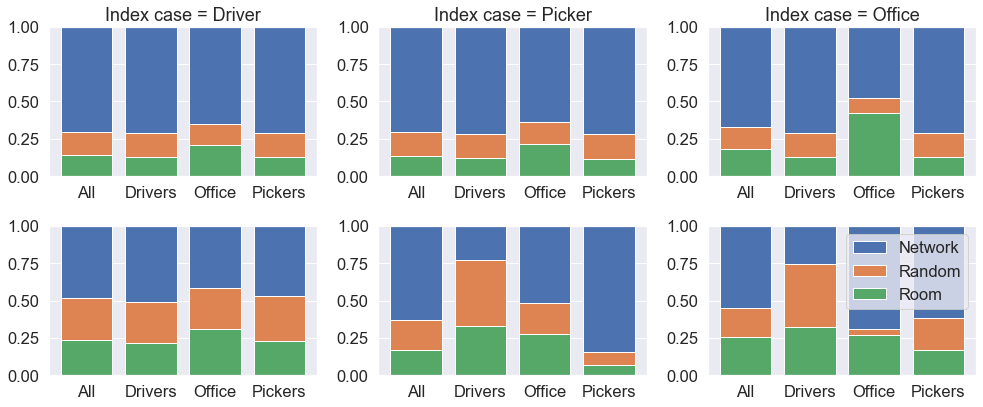

In [10]:
fig,ax = plt.subplots(2,3,figsize=(14,6))                
for k in np.arange(3):
    ax[0,k].bar(jobtypes, netinfs[:,len(TD)-1,len(Phi)-1,k] + \
                          continfs[:,len(TD)-1,len(Phi)-1,k] + \
                          roominfs[:,len(TD)-1,len(Phi)-1,k],label='Network')
    ax[0,k].bar(jobtypes, continfs[:,len(TD)-1,len(Phi)-1,k] + \
                          roominfs[:,len(TD)-1,len(Phi)-1,k],label='Random')
    ax[0,k].bar(jobtypes, roominfs[:,len(TD)-1,len(Phi)-1,k],label='Room')
    ax[1,k].bar(jobtypes, netinfs[:,2,0,k] + continfs[:,2,0,k] + \
                          roominfs[:,2,0,k],label='Network')
    ax[1,k].bar(jobtypes, continfs[:,2,0,k] + roominfs[:,2,0,k],label='Random')
    ax[1,k].bar(jobtypes, roominfs[:,2,0,k],label='Room')
    ax[0,k].set_ylim((0,1))
    ax[0,k].set_title('Index case = %s'%job[k])
    ax[1,k].set_ylim((0,1))
ax[1,2].legend()
fig.tight_layout()

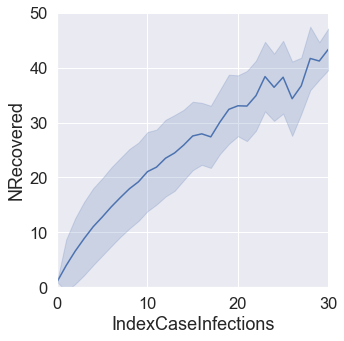

In [11]:
extreme_cases_df = df.loc[lambda df: (df['Group']=='All') & (df['FracRecovered']>10/df['NStaff'])]
#plt.hist(extreme_cases_df['FracRecovered'],bins=20)
figh = sns.relplot(x='IndexCaseInfections',y='NRecovered',data=df.loc[lambda df: (df['Group']=='All')],\
                   kind='line',ci='sd')
figh.set(xlim=(0,30),ylim=(0,50))